In [ ]:
import jax.numpy as np
import numpy as onp
from jax import random, jit, vmap, grad, device_put,nn
from jax.example_libraries import optimizers
import pandas as pd

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.unpack_archive('/content/drive/Shareddrives/ENM 531/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip')

In [ ]:
# !wget -r -N -c -np wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.3/

--2023-05-09 02:56:34--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2023-05-09 02:56:34--  https://physionet.org/files/ptb-xl/1.0.3/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/ptb-xl/1.0.3/index.html’

physionet.org/files     [ <=>                ]   1.39K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2023-05-09 02:56:34 (134 MB/s) - ‘physionet.org/files/ptb-xl/1.0.3/index.html’ saved [1421]

Loading robots.txt; please ignore errors.
--2023-05-09 02:56:34--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[=========

In [ ]:
! pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 7.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [ ]:
del list

NameError: ignored

In [ ]:
#one hot encoding : 'NORM':0,'CD':1,'MI':2,'HYP':3,'STTC':4
y_train=np.array(y_train)
reject_list=[]
train_one_hot=[]
y_train_new=[]
x_train_new=[]
for i in range(len(y_train)):
  if len(y_train[i])>0:
    x_train_new.append(X_train[i])
    y_train_new.append(y_train[i])

for i in range(len(y_train_new)):
  list=[0]*5
  for k in y_train_new[i]:
    if k=="NORM":
      list[0]=1
    if k=="CD":
      list[1]=1
    if k=="MI":
      list[2]=1
    if k=="HYP":
      list[3]=1
    if k=="STTC":
      list[4]=1
  train_one_hot.append(list)
train_one_hot=np.array(train_one_hot)
x_train_new=np.array(x_train_new)

In [ ]:
#one hot encoding : 'NORM':0,'CD':1,'MI':2,'HYP':3,'STTC':4
y_test=np.array(y_test)
reject_list=[]
test_one_hot=[]
y_test_new=[]
x_test_new=[]
for i in range(len(y_test)):
  if len(y_test[i])>0:
    x_test_new.append(X_test[i])
    y_test_new.append(y_test[i])

for i in range(len(y_test_new)):
  list=[0]*5
  for k in y_test_new[i]:
    if k=="NORM":
      list[0]=1
    if k=="CD":
      list[1]=1
    if k=="MI":
      list[2]=1
    if k=="HYP":
      list[3]=1
    if k=="STTC":
      list[4]=1
  test_one_hot.append(list)
test_one_hot=np.array(test_one_hot)
x_test_new=np.array(x_test_new)

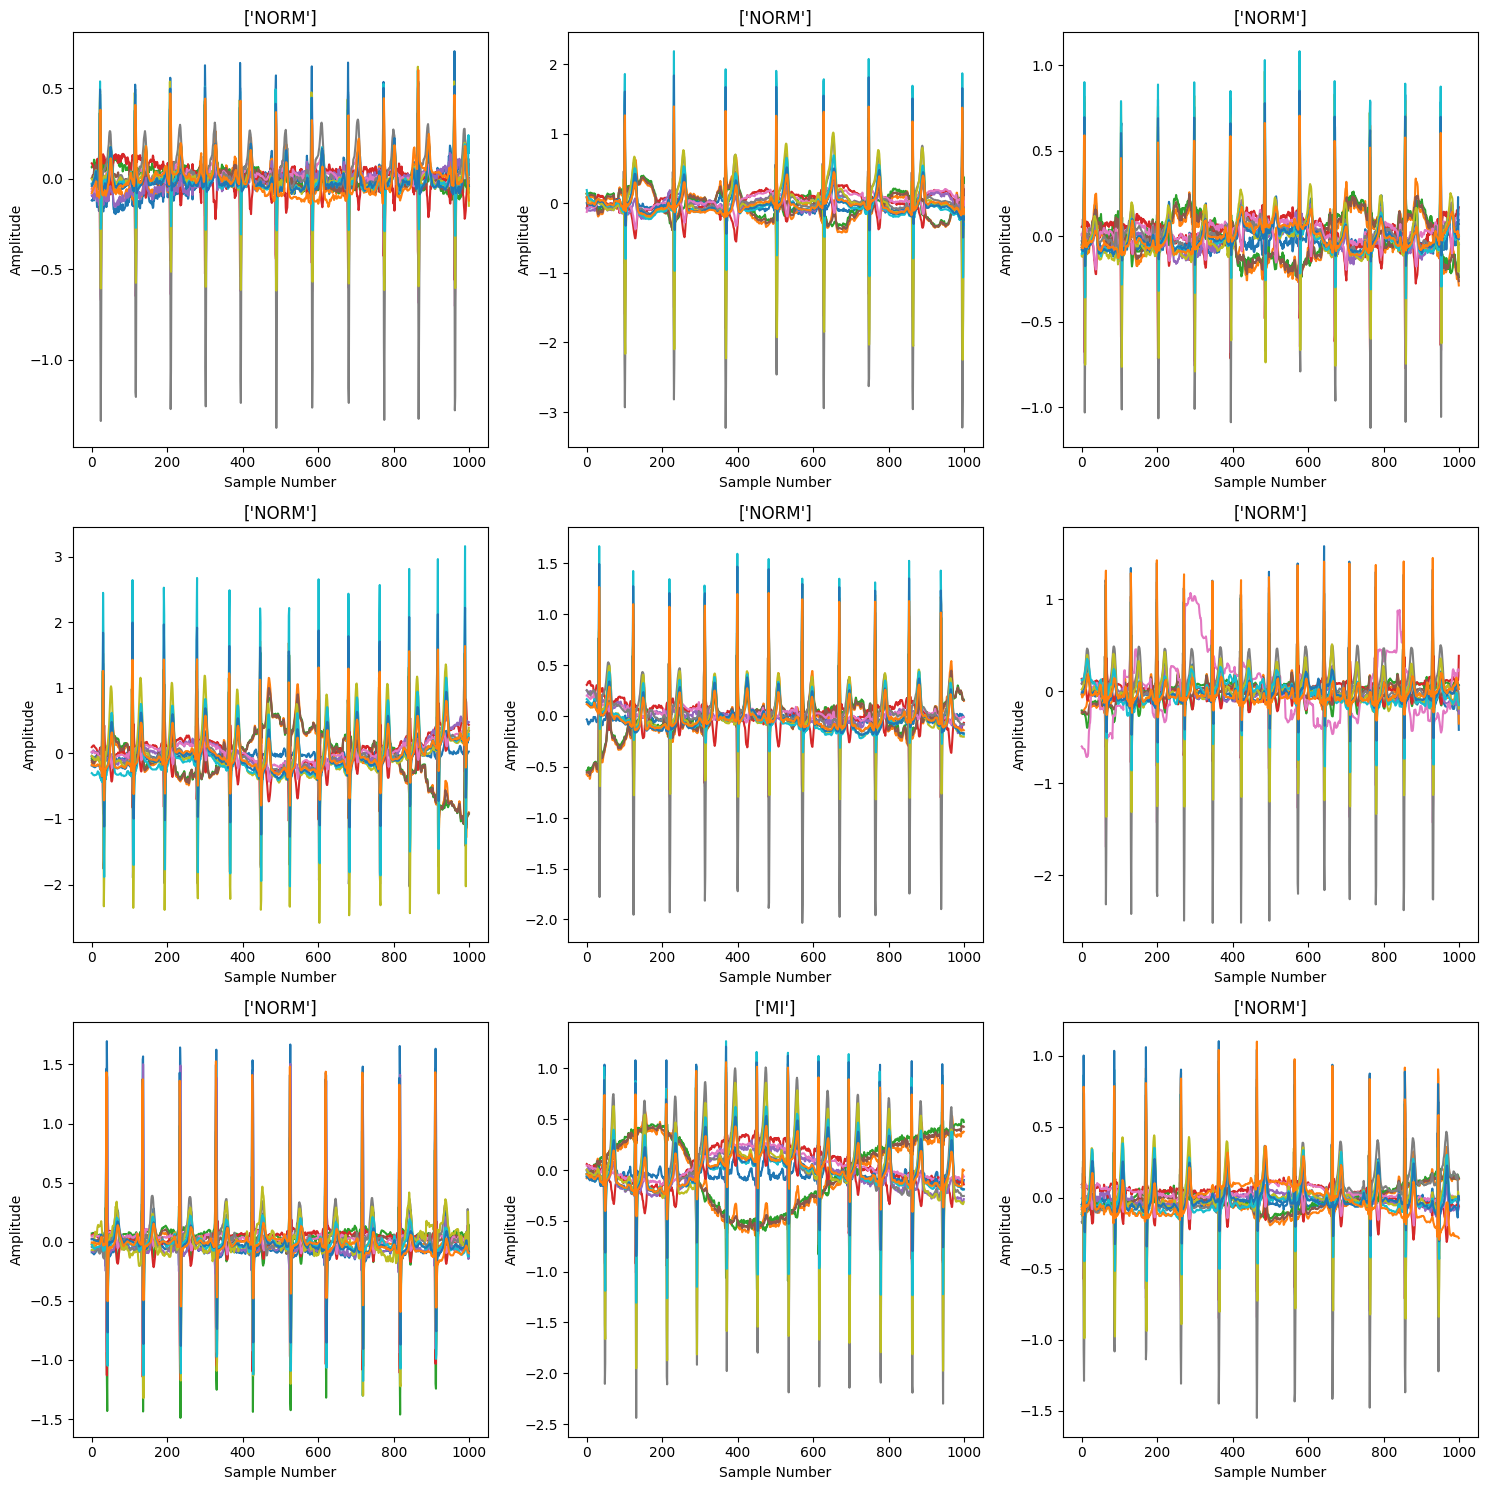

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    ax.plot(x_train_new[i])
    ax.set_title(y_train_new[i])
    ax.set_xlabel('Sample Number')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
#subsampling
sampling=500
rng=random.PRNGKey(0)
for i in x_train_new:
  id_start=int(np.floor(np.random.uniform(low=200,high=400)))
  id_stop=int(id_start+sampling)
  x_train_final=x_train_new[:,id_start:id_stop,:]

for i in x_test_new:
  id_start=int(np.floor(np.random.uniform(low=200,high=400)))
  id_stop=int(id_start+sampling)
  x_test_final=x_test_new[:,id_start:id_stop,:]

In [ ]:
#Normalizing the dataset:

X_mean,X_std=np.mean(x_train_final),np.std(x_train_final)
X_train=x_train_final
X_test=x_test_final

In [ ]:
del X,Y


In [ ]:
!pip install --upgrade flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from jax._src.api import value_and_grad
import jax.numpy as jnp
import numpy as np
from jax import random, vmap, grad, jit, value_and_grad

import flax.linen as nn
import optax
from sklearn.metrics import confusion_matrix

from typing import Any, Callable, Sequence, Optional, Union, Dict

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt

In [ ]:
# Some helper functions for visualization
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_filters(conv, shape, title):
    plt.figure(figsize=(5,4))
    cnt=0
    m, n = shape
    for i in range(m):
      for j in range(n):
          cnt+=1
          plt.subplot(m,n,cnt)   
          plt.imshow(conv[0,:,:,cnt]) 
          plt.axis('off')
    fig = plt.gcf()
    fig.suptitle(title)

In [ ]:
# code take from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html
googlenet_kernel_init = nn.initializers.kaiming_normal()

class InceptionBlock(nn.Module):
    c_red : dict  # Dictionary of reduced dimensionalities with keys "1x1", "3x3", "5x5", and "max"
    c_out : dict  # Dictionary of output feature sizes with keys "1x1", "3x3", "5x5", and "max"
    act_fn : callable # Activation function
    
    @nn.compact
    def __call__(self, x, train=True):
        # 1x1 convolution branch
        x_1x1 = nn.Conv(self.c_out["1x1"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_1x1 = nn.BatchNorm()(x_1x1, use_running_average=not train)
        x_1x1 = self.act_fn(x_1x1)
        
        # 3x3 convolution branch
        x_3x3 = nn.Conv(self.c_red["3x3"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_3x3 = nn.BatchNorm()(x_3x3, use_running_average=not train)
        x_3x3 = self.act_fn(x_3x3)
        x_3x3 = nn.Conv(self.c_out["3x3"], kernel_size=(3, 3), kernel_init=googlenet_kernel_init, use_bias=False)(x_3x3)
        x_3x3 = nn.BatchNorm()(x_3x3, use_running_average=not train)
        x_3x3 = self.act_fn(x_3x3)
        
        # 5x5 convolution branch
        x_5x5 = nn.Conv(self.c_red["5x5"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_5x5 = nn.BatchNorm()(x_5x5, use_running_average=not train)
        x_5x5 = self.act_fn(x_5x5)
        x_5x5 = nn.Conv(self.c_out["5x5"], kernel_size=(5, 5), kernel_init=googlenet_kernel_init, use_bias=False)(x_5x5)
        x_5x5 = nn.BatchNorm()(x_5x5, use_running_average=not train)
        x_5x5 = self.act_fn(x_5x5)
        
        # Max-pool branch
        x_max = nn.max_pool(x, (3, 3), strides=(2, 2))
        x_max = nn.Conv(self.c_out["max"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_max = nn.BatchNorm()(x_max, use_running_average=not train)
        x_max = self.act_fn(x_max)
        
        x_out = jnp.concatenate([x_1x1, x_3x3, x_5x5, x_max], axis=-1)
        return x_out

In [ ]:
# code take from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html
class GoogleNet(nn.Module):
    num_classes : int
    act_fn : callable=nn.relu
        
    @nn.compact
    def __call__(self, x, train=True):
        # A first convolution on the original image to scale up the channel size
        x = nn.Conv(64, kernel_size=(3, 3), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)
            
        # Stacking inception blocks
        inception_blocks = [
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.act_fn),
            lambda inp: nn.max_pool(inp, (3, 3), strides=(2, 2)),  # 32x32 => 16x16
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.act_fn),
            lambda inp: nn.max_pool(inp, (3, 3), strides=(2, 2)),  # 16x16 => 8x8
            InceptionBlock(c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.act_fn)
        ]
        for block in inception_blocks:
            x = block(x, train=train) if isinstance(block, InceptionBlock) else block(x)
        
        # Mapping to classification output
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_classes)(x)
        return nn.softmax(x)

In [ ]:

# Defining the keys for the model and the data loader:
# Doing this before due to some strange bug on JAX (REF:https://github.com/google/jax/issues/15084)
rng_model = random.PRNGKey(0)
rng_dataloader = random.PRNGKey(42)

In [ ]:

class CNNclassifier:
    # Initialize the class
    def __init__(self, arch, rng_key=random.PRNGKey(0)):
        
        # Initialization and evaluation functions
        inputs = jnp.ones((512,500,12,1))
        self.model = arch
        self.variables=self.model.init(rng_key,inputs,train=True)
        self.params, self.batch_stats = self.variables['params'], self.variables['batch_stats']
        print(self.model.tabulate(rng_key, inputs))

        # Optimizer
        lr = optax.exponential_decay(1e-3, transition_steps=1000, decay_rate=0.9)
        self.optimizer = optax.adam(learning_rate=lr)
        self.opt_state = self.optimizer.init(self.params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
    @partial(jit, static_argnums=(0,))
    def loss(self, params,batch_stats, batch):
        images, labels = batch
        vars_in = {'params': params, 'batch_stats': batch_stats}
        outputs,mutated_vars = self.model.apply(vars_in, images,mutable=['batch_stats'])
        new_batch_stats=mutated_vars['batch_stats']
        outputs=outputs+1e-7
        loss=-labels*jnp.log(outputs)
        return jnp.mean(loss),new_batch_stats

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, params,batch_stats, opt_state, batch):
        grads,batch_stats = grad(self.loss,has_aux=True)(params,batch_stats, batch)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params,batch_stats, opt_state

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.params,self.batch_stats,self.opt_state = self.step(self.params,self.batch_stats,self.opt_state, batch)
            # Logger
            if it % 100 == 0:
                loss,_ = self.loss(self.params,self.batch_stats, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self,inputs):
        rng=random.PRNGKey(23)
        key,subkey=random.split(rng)
        vars_in = {'params': self.params, 'batch_stats': self.batch_stats}
        outputs = self.model.apply(vars_in, inputs,train=False)
        return outputs
     

In [ ]:
import torchvision as tv
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, images, labels, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.labels = labels
        self.N = labels.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images, labels):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        images = images[idx,...]
        labels = labels[idx,...]
        return images, labels

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        images, labels = self.__data_generation(self.key, self.images, self.labels)
        return images, labels

In [ ]:
train_images = X_train[:,:,:,np.newaxis]
train_labels = train_one_hot

# Create data iteraror
train_dataset = DataGenerator(train_images, train_labels, batch_size=128, rng_key = rng_dataloader)

In [ ]:

# Initialize model
arch = GoogleNet(num_classes=5)
model=CNNclassifier(arch)


                               GoogleNet Summary                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ params     ┃ batch_stats ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│            │ GoogleNet  │ float32[5… │ float32[5… │            │             │
├────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ Conv_0     │ Conv       │ float32[5… │ float32[5… │ kernel:    │             │
│            │            │            │            │ float32[3… │             │
│            │            │            │            │            │             │
│            │            │            │            │ 576 (2.3   │             │
│            │            │            │            │ KB)        │             │
├────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ BatchNorm… │ BatchNorm  │

100%|██████████| 7000/7000 [37:32<00:00,  3.11it/s, loss=0.08370905]


Text(0, 0.5, 'Loss')

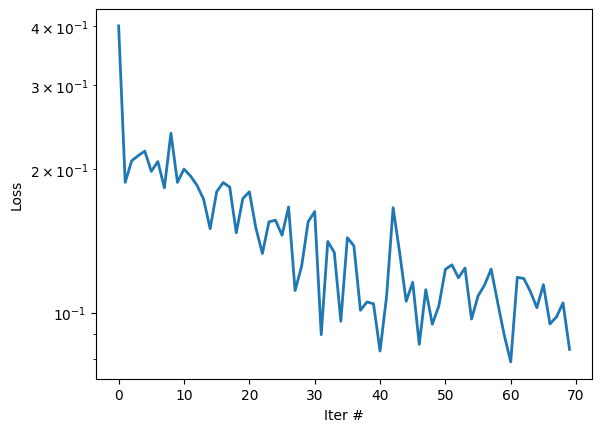

In [ ]:
# Train model
model.train(train_dataset, nIter=7000)
#opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
test_images = X_test[:,:,:,np.newaxis]
test_labels = test_one_hot


# Create data iteraror
test_dataset = DataGenerator(test_images, test_labels, batch_size=128)
test_data = iter(test_dataset)

In [ ]:

# Compute classification accuracy on the entire test data-set
@jit
def accuracy(batch):
    images, labels = batch
    outputs = model.predict(images)
    pred_class = np.argmax(outputs,1)
    true_class = np.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

acc = accuracy((test_images, test_labels))
print('Classification accuracy: {}%'.format(100*acc))

Classification accuracy: 69.46246337890625%


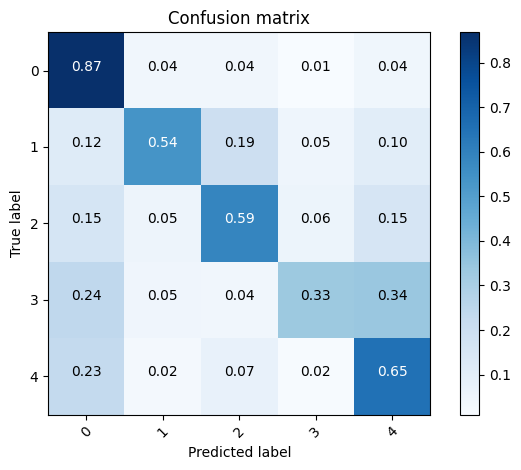

In [ ]:
num_classes=5
outputs = model.predict(test_images)
pred_class = np.argmax(outputs,1)
true_class = np.argmax(test_labels,1)
M = confusion_matrix(true_class, pred_class)
plt.figure()
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=True)

In [ ]:
from sklearn.metrics import f1_score

f1_score = f1_score(true_class, pred_class, average='weighted')


In [ ]:
f1_score

### With Skip Connections:

In [ ]:
# code take from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html
googlenet_kernel_init = nn.initializers.kaiming_normal()

class InceptionBlock(nn.Module):
    c_red : dict  # Dictionary of reduced dimensionalities with keys "1x1", "3x3", "5x5", and "max"
    c_out : dict  # Dictionary of output feature sizes with keys "1x1", "3x3", "5x5", and "max"
    act_fn : callable # Activation function
    
    @nn.compact
    def __call__(self, x, train=True):
        # 1x1 convolution branch
        x_1x1 = nn.Conv(self.c_out["1x1"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_1x1 = nn.BatchNorm()(x_1x1, use_running_average=not train)
        x_1x1 = self.act_fn(x_1x1)
        
        # 3x3 convolution branch
        x_3x3 = nn.Conv(self.c_red["3x3"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_3x3 = nn.BatchNorm()(x_3x3, use_running_average=not train)
        x_3x3 = self.act_fn(x_3x3)
        x_3x3 = nn.Conv(self.c_out["3x3"], kernel_size=(3, 3), kernel_init=googlenet_kernel_init, use_bias=False)(x_3x3)
        x_3x3 = nn.BatchNorm()(x_3x3, use_running_average=not train)
        x_3x3 = self.act_fn(x_3x3)
        
        # 5x5 convolution branch
        x_5x5 = nn.Conv(self.c_red["5x5"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_5x5 = nn.BatchNorm()(x_5x5, use_running_average=not train)
        x_5x5 = self.act_fn(x_5x5)
        x_5x5 = nn.Conv(self.c_out["5x5"], kernel_size=(5, 5), kernel_init=googlenet_kernel_init, use_bias=False)(x_5x5)
        x_5x5 = nn.BatchNorm()(x_5x5, use_running_average=not train)
        x_5x5 = self.act_fn(x_5x5)
        
        # Max-pool branch
        x_max = nn.max_pool(x, (3, 3), strides=(2, 2))
        x_max = nn.Conv(self.c_out["max"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_max = nn.BatchNorm()(x_max, use_running_average=not train)
        x_max = self.act_fn(x_max)
        
        x_out = jnp.concatenate([x_1x1, x_3x3, x_5x5, x_max], axis=-1)
        return x_out

In [ ]:
# code take from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html

class GoogleNet(nn.Module):
    num_classes : int
    act_fn : callable=nn.relu
        
    @nn.compact
    def __call__(self, x, train=True):
        # A first convolution on the original image to scale up the channel size
        x = nn.Conv(96, kernel_size=(3, 3), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)
            
        # Stacking inception blocks
        inception_blocks = [
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.act_fn),
            lambda inp: nn.max_pool(inp, (3, 3), strides=(2, 2)),  # 32x32 => 16x16
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.act_fn),
            lambda inp: nn.max_pool(inp, (3, 3), strides=(2, 2)),  # 16x16 => 8x8
            InceptionBlock(c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.act_fn)
        ]
       # for block in inception_blocks:
        #    x = block(x, train=train) if isinstance(block, InceptionBlock) else block(x)
        count=0
        for block in inception_blocks:
            if count==0 or count==1 or count==2:
              skip=x
            if isinstance(block,InceptionBlock):
              x=block(x,train=train)
            else:
              x=x+skip
              x=block(x)
              count+=1
        x=x+skip
       # Mapping to classification output
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_classes)(x)
        return nn.softmax(x)

In [ ]:
rng_model = random.PRNGKey(0)
rng_dataloader = random.PRNGKey(42)

In [ ]:
class CNNclassifier:
    # Initialize the class
    def __init__(self, arch, rng_key=random.PRNGKey(0)):
        
        # Initialization and evaluation functions
        inputs = jnp.ones((512,500,12,1))
        self.model = arch
        self.variables=self.model.init(rng_key,inputs,train=True)
        self.params, self.batch_stats = self.variables['params'], self.variables['batch_stats']
        print(self.model.tabulate(rng_key, inputs))

        # Optimizer
        lr = optax.exponential_decay(1e-3, transition_steps=1000, decay_rate=0.9)
        self.optimizer = optax.adam(learning_rate=lr)
        self.opt_state = self.optimizer.init(self.params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
    @partial(jit, static_argnums=(0,))
    def loss(self, params,batch_stats, batch):
        images, labels = batch
        vars_in = {'params': params, 'batch_stats': batch_stats}
        outputs,mutated_vars = self.model.apply(vars_in, images,mutable=['batch_stats'])
        new_batch_stats=mutated_vars['batch_stats']
        outputs=outputs+1e-7
        loss=-labels*jnp.log(outputs)
        return jnp.mean(loss),new_batch_stats

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, params,batch_stats, opt_state, batch):
        grads,batch_stats = grad(self.loss,has_aux=True)(params,batch_stats, batch)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params,batch_stats, opt_state

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.params,self.batch_stats,self.opt_state = self.step(self.params,self.batch_stats,self.opt_state, batch)
            # Logger
            if it % 100 == 0:
                loss,_ = self.loss(self.params,self.batch_stats, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self,inputs):
        rng=random.PRNGKey(23)
        key,subkey=random.split(rng)
        vars_in = {'params': self.params, 'batch_stats': self.batch_stats}
        outputs = self.model.apply(vars_in, inputs,train=False)
        return outputs

In [ ]:
import torchvision as tv
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, images, labels, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.labels = labels
        self.N = labels.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images, labels):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        images = images[idx,...]
        labels = labels[idx,...]
        return images, labels

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        images, labels = self.__data_generation(self.key, self.images, self.labels)
        return images, labels

In [ ]:
arch = GoogleNet(num_classes=5)
model=CNNclassifier(arch)


                               GoogleNet Summary                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ params     ┃ batch_stats ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│            │ GoogleNet  │ float32[5… │ float32[5… │            │             │
├────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ Conv_0     │ Conv       │ float32[5… │ float32[5… │ kernel:    │             │
│            │            │            │            │ float32[3… │             │
│            │            │            │            │            │             │
│            │            │            │            │ 864 (3.5   │             │
│            │            │            │            │ KB)        │             │
├────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ BatchNorm… │ BatchNorm  │

In [ ]:
train_images = X_train[:,:,:,np.newaxis]
train_labels = train_one_hot

# Create data iteraror
train_dataset = DataGenerator(train_images, train_labels, batch_size=128, rng_key = rng_dataloader)

100%|██████████| 7000/7000 [38:01<00:00,  3.07it/s, loss=0.08400161]


Text(0, 0.5, 'Loss')

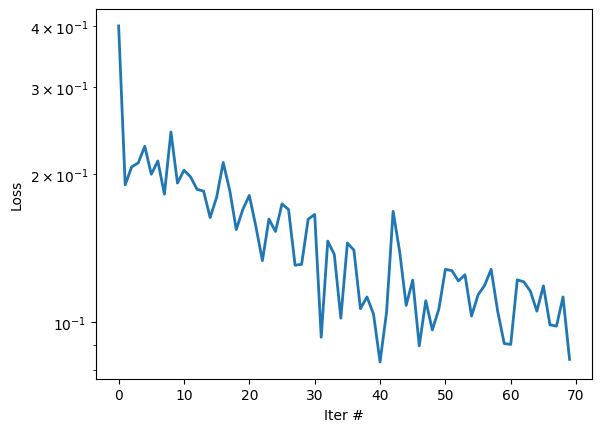

In [ ]:
model.train(train_dataset, nIter=7000)
#opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
test_images = X_test[:,:,:,np.newaxis]
test_labels = test_one_hot


# Create data iteraror
test_dataset = DataGenerator(test_images, test_labels, batch_size=128)
test_data = iter(test_dataset)

In [ ]:
@jit
def accuracy(batch):
    images, labels = batch
    outputs = model.predict(images)
    pred_class = np.argmax(outputs,1)
    true_class = np.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

acc = accuracy((test_images, test_labels))
print('Classification accuracy: {}%'.format(100*acc))

Classification accuracy: 68.58202362060547%


In [ ]:
def f1_score(y_true, y_pred):
    tp = jnp.sum(y_true * y_pred)
    fp = jnp.sum((1 - y_true) * y_pred)
    fn = jnp.sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + 1e-16)
    recall = tp / (tp + fn + 1e-16)
    f1 = 2 * precision * recall / (precision + recall + 1e-16)
    return f1


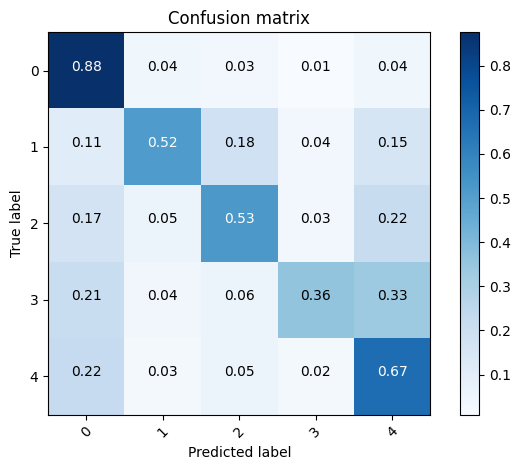

In [ ]:
num_classes=5
outputs = model.predict(test_images)
pred_class = np.argmax(outputs,1)
true_class = np.argmax(test_labels,1)
M = confusion_matrix(true_class, pred_class)
plt.figure()
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=True)

In [ ]:
from sklearn.metrics import f1_score

f1_score = f1_score(true_class, pred_class, average='weighted')


In [ ]:
f1_score

0.6835326083959985

### ResNet

In [ ]:
# code take from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html
resnet_kernel_init = nn.initializers.variance_scaling(2.0, mode='fan_out', distribution='normal')

class ResNetBlock(nn.Module):
    act_fn : callable  # Activation function
    c_out : int   # Output feature size
    subsample : bool = False  # If True, we apply a stride inside F

    @nn.compact
    def __call__(self, x, train=True):
        # Network representing F
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    strides=(1, 1) if not self.subsample else (2, 2),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(x)
        z = nn.BatchNorm()(z, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)
        z = nn.BatchNorm()(z, use_running_average=not train)

        if self.subsample:
            x = nn.Conv(self.c_out, kernel_size=(1, 1), strides=(2, 2), kernel_init=resnet_kernel_init)(x)

        x_out = self.act_fn(z + x)
        return x_out

In [ ]:
# code take from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html
class PreActResNetBlock(ResNetBlock):

    @nn.compact
    def __call__(self, x, train=True):
        # Network representing F
        z = nn.BatchNorm()(x, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    strides=(1, 1) if not self.subsample else (2, 2),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)
        z = nn.BatchNorm()(z, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)

        if self.subsample:
            x = nn.BatchNorm()(x, use_running_average=not train)
            x = self.act_fn(x)
            x = nn.Conv(self.c_out,
                        kernel_size=(1, 1),
                        strides=(2, 2),
                        kernel_init=resnet_kernel_init,
                        use_bias=False)(x)

        x_out = z + x
        return x_out

In [ ]:
# code take from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html
class ResNet(nn.Module):
    num_classes : int
    act_fn : callable
    block_class : nn.Module
    num_blocks : tuple = (3, 3, 3)
    c_hidden : tuple = (16, 32, 64)

    @nn.compact
    def __call__(self, x, train=True):
        # A first convolution on the original image to scale up the channel size
        x = nn.Conv(self.c_hidden[0], kernel_size=(3, 3), kernel_init=resnet_kernel_init, use_bias=False)(x)
        if self.block_class == ResNetBlock:  # If pre-activation block, we do not apply non-linearities yet
            x = nn.BatchNorm()(x, use_running_average=not train)
            x = self.act_fn(x)

        # Creating the ResNet blocks
        for block_idx, block_count in enumerate(self.num_blocks):
            for bc in range(block_count):
                # Subsample the first block of each group, except the very first one.
                subsample = (bc == 0 and block_idx > 0)
                # ResNet block
                x = self.block_class(c_out=self.c_hidden[block_idx],
                                     act_fn=self.act_fn,
                                     subsample=subsample)(x, train=train)

        # Mapping to classification output
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_classes)(x)
        return nn.softmax(x)

In [ ]:
rng_model = random.PRNGKey(0)
rng_dataloader = random.PRNGKey(42)

In [ ]:
class CNNclassifier:
    # Initialize the class
    def __init__(self, arch, rng_key=random.PRNGKey(0)):
        
        # Initialization and evaluation functions
        inputs = jnp.ones((512,500,12,1))
        self.model = arch
        self.variables=self.model.init(rng_key,inputs,train=True)
        self.params, self.batch_stats = self.variables['params'], self.variables['batch_stats']
        print(self.model.tabulate(rng_key, inputs))

        # Optimizer
        lr = optax.exponential_decay(1e-3, transition_steps=1000, decay_rate=0.9)
        self.optimizer = optax.adam(learning_rate=lr)
        self.opt_state = self.optimizer.init(self.params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
    @partial(jit, static_argnums=(0,))
    def loss(self, params,batch_stats, batch):
        images, labels = batch
        vars_in = {'params': params, 'batch_stats': batch_stats}
        outputs,mutated_vars = self.model.apply(vars_in, images,mutable=['batch_stats'])
        new_batch_stats=mutated_vars['batch_stats']
        outputs=outputs+1e-7
        loss=-labels*jnp.log(outputs)
        return jnp.mean(loss),new_batch_stats

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, params,batch_stats, opt_state, batch):
        grads,batch_stats = grad(self.loss,has_aux=True)(params,batch_stats, batch)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params,batch_stats, opt_state

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.params,self.batch_stats,self.opt_state = self.step(self.params,self.batch_stats,self.opt_state, batch)
            # Logger
            if it % 100 == 0:
                loss,_ = self.loss(self.params,self.batch_stats, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self,inputs):
        rng=random.PRNGKey(23)
        key,subkey=random.split(rng)
        vars_in = {'params': self.params, 'batch_stats': self.batch_stats}
        outputs = self.model.apply(vars_in, inputs,train=False)
        return outputs

In [ ]:
arch = ResNet(num_classes=5,act_fn=nn.relu,block_class=ResNetBlock)
model=CNNclassifier(arch)


                                 ResNet Summary                                 
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ params      ┃ batch_sta… ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│            │ ResNet     │ float32[5… │ float32[5… │             │            │
├────────────┼────────────┼────────────┼────────────┼─────────────┼────────────┤
│ Conv_0     │ Conv       │ float32[5… │ float32[5… │ kernel:     │            │
│            │            │            │            │ float32[3,… │            │
│            │            │            │            │             │            │
│            │            │            │            │ 144 (576 B) │            │
├────────────┼────────────┼────────────┼────────────┼─────────────┼────────────┤
│ BatchNorm… │ BatchNorm  │ -          │ float32[5… │ bias:       │ mean:      │
│            │            │

100%|██████████| 7000/7000 [35:34<00:00,  3.28it/s, loss=0.07633275]


Text(0, 0.5, 'Loss')

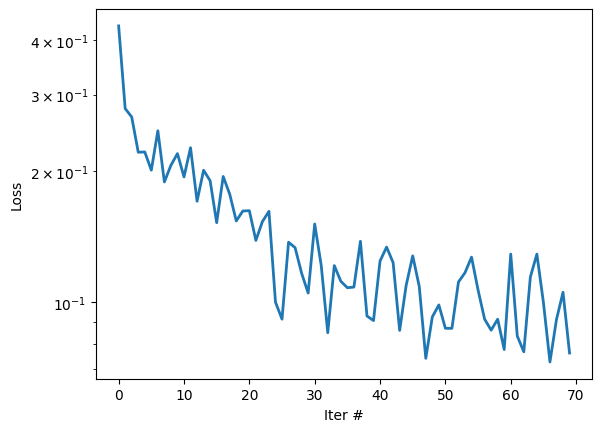

In [ ]:
model.train(train_dataset, nIter=7000)
#opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
def accuracy(batch):
    images, labels = batch
    outputs = model.predict(images)
    pred_class = np.argmax(outputs,1)
    true_class = np.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

acc = accuracy((test_images, test_labels))
print('Classification accuracy: {}%'.format(100*acc))

Classification accuracy: 69.36978912353516%


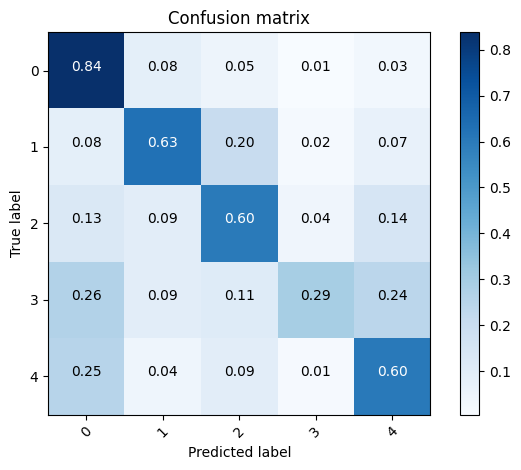

In [ ]:
num_classes=5
outputs = model.predict(test_images)
pred_class = np.argmax(outputs,1)
true_class = np.argmax(test_labels,1)
M = confusion_matrix(true_class, pred_class)
plt.figure()
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=True)

In [ ]:
from sklearn.metrics import f1_score

f1_score = f1_score(true_class, pred_class, average='weighted')


In [ ]:
f1_score

0.6905008826092582